Read in packages and set up environment

In [1]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import os
import geopandas as gpd
import fiona
import rasterio.plot
import matplotlib as mpl
# from descartes import PolygonPatch

Define methods for splitting into multiple peaks, and shorthands ways to refer to them used in filepaths

In [2]:
methods = {'singlepeak': "6hr_sp", 'dividetime':"6hr_dt", 'maxspread': "6hr_ms", "subpeaktiming": "6hr_sp-t"}

### Find the proportion of cells in the catchment which were flooded with particular depths or velocities

Define whether to remove values < 0.1

In [3]:
remove_little_values = True

Loop through methods and populate dataframes

In [4]:
os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/")

# Define the names of the methods, and the shorthand versions of the names used in the folder naming conventions
method_names_dict =  {'singlepeak' : 'sp', 'dividetime' : 'dt', 'subpeaktiming' : 'sp-t', 'maxspread': 'ms'}    

For each method, read in the raster file containing the depth and velocity values and convert to array.   
If "remove_little_values" is True, and therefore we want to consider only cells with flooding > 0.1m then: set any values in the depth array which are less than 0.1 to 0, and also set the equivalent cells in the velocity values array to 0.

In [5]:
results_dict = {}
for variable in ["depth", "velocity"]:
    counts_df = pd.DataFrame()
    proportions_df = pd.DataFrame()        

    for method_name, shortening in methods.items():    # Define filepath
        print(variable, method_name)
        # Read in the raster files
        raster = rasterio.open("MeganModel/{}_u/6hr_{}_{}.Resampled.Terrain.tif".format(shortening, method_name, variable)).read(1)
        # Set -9999 to NA
        raster[raster < -9998] = np.nan    
        # Set cell values to Null in cells which have a value <0.1 in the depth raster
        if remove_little_values == True:
             raster[raster < 0.1] = np.nan
        unique, counts = np.unique(raster, return_counts=True)
        df = pd.DataFrame({'values': unique, 'counts':counts})
        # Cut by depth bins
        if variable == 'depth':
            df['bins']= pd.cut(unique, bins=[0,0.1,0.15,0.30,0.60, 0.9, 1.2,5,99], right=False)
        elif variable == 'velocity':
            df['bins']= pd.cut(unique, bins=[0,0.25,0.50,1,2,3], right=False)
        groups = df.groupby(['bins']).sum()
        groups  = groups.reset_index()
        # Find the sum
        total_n_cells = groups ['counts'].sum()
        # Find the number of cells in each group as a proportion of the total
        groups['Proportion'] = round((groups['counts']/total_n_cells) *100,1)
        
        # Add values to dataframes
        counts_df[method_name] = groups['counts']
        proportions_df[method_name] = groups['Proportion']
        
    # Reset index to show the groups
    counts_df.reset_index(inplace=True)
    proportions_df.reset_index(inplace=True)
    
    # Set index values
    if variable == 'depth':
        counts_df['index'] = ['0-0.1m', '0.1-0.15m', '0.15-0.3m', '0.3-0.6m', '0.6-0.9m', '0.9-1.2m', '1.2-5m', '5m+']
        proportions_df['index'] = ['0-0.1m', '0.1-0.15m', '0.15-0.3m', '0.3-0.6m', '0.6-0.9m', '0.9-1.2m', '1.2-5m', '5m+']
    elif variable == 'velocity':
        counts_df['index'] = ['0-0.25m/s', '0.25-0.5m/s', '0.5-1m/s','1-2m/s', '2-3m/s']
        proportions_df['index'] = ['0-0.25m/s', '0.25-0.5m/s', '0.5-1m/s','1-2m/s','2-3m/s']

    # Add to dictionary
    results_dict['{}_counts'.format(variable)] = counts_df
    results_dict['{}_props'.format(variable)] = proportions_df

depth singlepeak
depth dividetime
depth maxspread
depth subpeaktiming
velocity singlepeak
velocity dividetime
velocity maxspread
velocity subpeaktiming


Create a dataframe for both depth and velocity showing the number of cells with flooding with certain depths and velocities

###  Plot the total number of flooded cells and the total flooded area (this is assuming grid cells are 5m by 5m - but need to check this is correct)
This plot is the same whether you use depth or velocity as the variable

In [11]:
# Create dataframe with just totals 
variable = 'velocity'
counts_df = results_dict['{}_counts'.format(variable)]
totals_df = counts_df.append(counts_df.sum(numeric_only=True), ignore_index=True)
totals_df = totals_df.iloc[[len(totals_df)-1]]
totals_df.drop(columns = 'index', inplace = True)

# Convert this 
totals_df_area = (totals_df * 25)/1000000

#### Get a list of the percentage difference in the total number of flooded cells using the other methods

In [12]:
ls = []
for method in methods.keys():
    if method!= 'singlepeak':
        ls.append((totals_df[method]/totals_df['singlepeak'] - 1).map('{:.2%}'.format).values[0])
ls = ['+'  + s for s in ls]
ls = [''] + ls

#### Plot

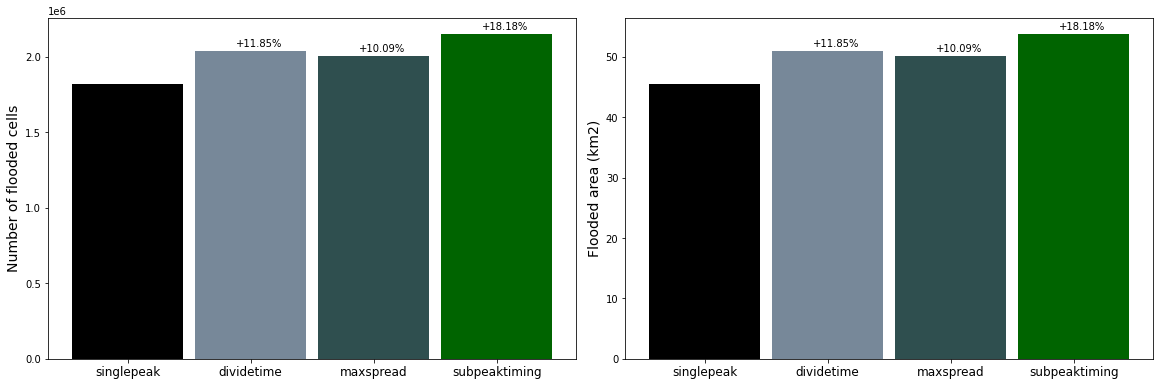

In [16]:
# Set colors for plots
colors = ['black', 'lightslategrey', 'darkslategrey', 'darkgreen']

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,10))
y_pos = np.arange(len(methods.keys()))

##############################
# Plot number of flooded cells
##############################
plt.subplot(221)
plt.bar(y_pos, totals_df.iloc[[0]].values.tolist()[0], color=colors,
        width = 0.9)
# Create names on the x-axis
plt.xticks(y_pos, methods.keys(), fontsize =12 )
# plt.xlabel('Method')
plt.ylabel('Number of flooded cells', fontsize =14 )

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]

for i, v in enumerate(totals_df.iloc[[0]].values.tolist()[0]):
    plt.text(xlocs[i] - 1.12, v * 1.015, str(ls[i]))

# ##############################
# # Plot flooded extent in m2
# ##############################
plt.subplot(222)
plt.bar(y_pos, totals_df_area.iloc[[0]].values.tolist()[0], color=colors,
        width = 0.9)
# Create names on the x-axis
plt.xticks(y_pos, methods.keys(), fontsize =12 )
# plt.xlabel('Method')
plt.ylabel('Flooded area (km2)', fontsize =14 )

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]

for i, v in enumerate(totals_df_area.iloc[[0]].values.tolist()[0]):
    plt.text(xlocs[i] - 1.12, v * 1.015, str(ls[i]))

###  Plot the number and proportion of flooded cells with different depth and velocity categories

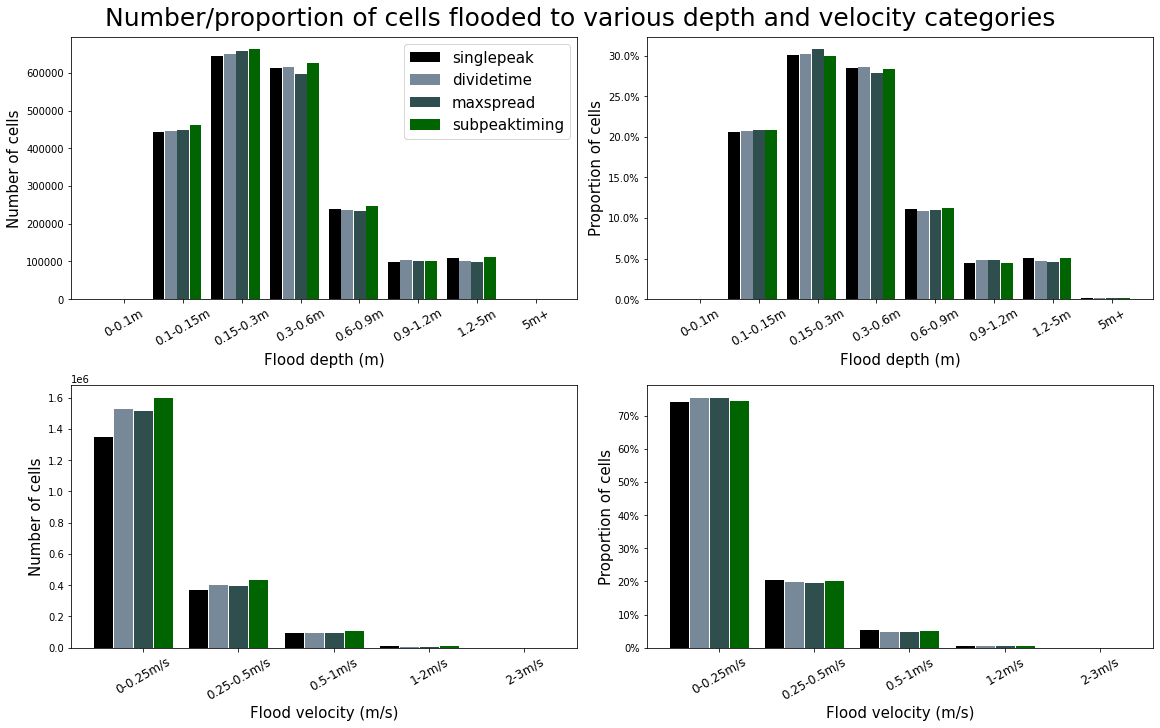

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize = (16,10))
fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222, 223, 224]
subplot_i = 0

units_dict = {'depth': 'm', 'velocity': 'm/s'}    

for row, variable in enumerate(["depth", "velocity"]):

    counts_df = results_dict['{}_counts'.format(variable)]
    proportions_df = results_dict['{}_props'.format(variable)]
    
    ################# Plot
    labels = counts_df['index']
    x = np.arange(len(counts_df['index']))
    width = 0.3
    
    # counts_df plotting
    width, DistBetweenBars, Num = 0.2, 0.01, 4 # width of each bar, distance between bars, number of bars in a group
    # calculate the width of the grouped bars (including the distance between the individual bars)
    WithGroupedBars = Num*width + (Num-1)*DistBetweenBars
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, counts_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(counts_df['index'])), counts_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Number of cells', fontsize = 15)
    # Put legend on top left plot
    if subplot_i == 0:
        plt.legend(counts_df.columns[1:], fontsize=15, frameon = True)
   
    # Proportions_df plotting
    subplot_i = subplot_i+ 1        
    plt.subplot(subplot_n[subplot_i])
    for i in range(Num):
        plt.bar(np.arange(len(counts_df))-WithGroupedBars/2 + (width+DistBetweenBars)*i, proportions_df.iloc[:,i+1], width, 
                color = colors[i])
    plt.xticks(np.arange(len(proportions_df['index'])), proportions_df['index'], rotation=30, fontsize = 12)
    plt.xlabel('Flood {} ({})'.format(variable, units_dict[variable]), fontsize = 15)
    plt.ylabel('Proportion of cells', fontsize = 15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    subplot_i = subplot_i+ 1 


### Stacked bar chart - plotting the total number of flood cells with breakdown by categories

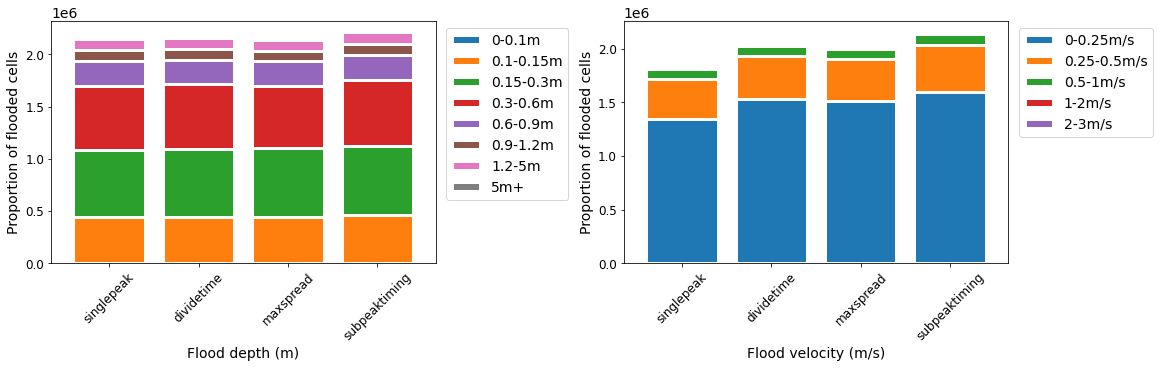

In [214]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,5))
# fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222]
subplot_i = 0

units_dict = {'depth': 'm', 'velocity': 'm/s'}    

for row, variable in enumerate(["depth", "velocity"]):
    # Get the dataframes
    counts_df = results_dict['{}_counts'.format(variable)]
    proportions_df = results_dict['{}_props'.format(variable)]
    
    # reformat the dataframe for stacked plotting
    reformatted_df  =counts_df.T[1:]
    if row == 1:
        reformatted_df.columns = ['0-0.25m/s', '0.25-0.5m/s', '0.5-1m/s','1-2m/s', '2-3m/s']
    else:
        reformatted_df.columns = ['0-0.1m', '0.1-0.15m', '0.15-0.3m', '0.3-0.6m', '0.6-0.9m', '0.9-1.2m', '1.2-5m', '5m+']
    # Plot   
    reformatted_df.plot(ax=axs[row], kind='bar', edgecolor='white', linewidth=3, stacked = True, width =0.8, rot =45,
                         xlabel = 'Flood {} ({})'.format(variable, units_dict[variable]),
                            ylabel = 'Proportion of flooded cells', fontsize = 12)
    
    plt.rcParams.update({'font.size': 14})
    axs[row].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

### Stacked bar chart - proportion of total num flooded cells made up by each depth/velocity category

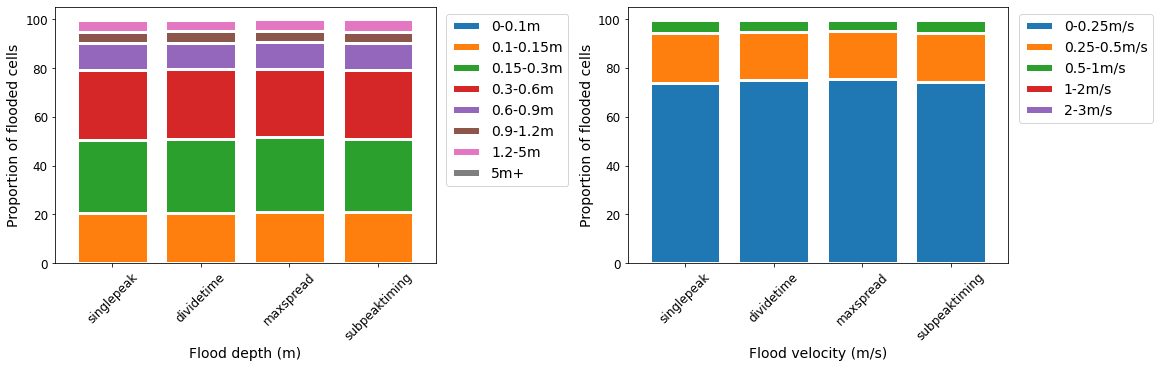

In [201]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,5))
# fig.suptitle('Number/proportion of cells flooded to various depth and velocity categories', fontsize = 25)
subplot_n = [221, 222]

units_dict = {'depth': 'm', 'velocity': 'm/s'}    

for row, variable in enumerate(["depth", "velocity"]):
    # Get the dataframes
    counts_df = results_dict['{}_counts'.format(variable)]
    proportions_df = results_dict['{}_props'.format(variable)]
    
    # reformat the dataframe for stacked plotting
    reformatted_df  =proportions_df.T[1:]
    if row == 1:
        reformatted_df.columns = ['0-0.25m/s', '0.25-0.5m/s', '0.5-1m/s','1-2m/s', '2-3m/s']
    else:
        reformatted_df.columns = ['0-0.1m', '0.1-0.15m', '0.15-0.3m', '0.3-0.6m', '0.6-0.9m', '0.9-1.2m', '1.2-5m', '5m+']
    # Plot
#     width = 1 / len(bar_lefts)
    reformatted_df.plot(ax=axs[row], kind='bar', edgecolor='white', linewidth=3, stacked = True, width =0.8, rot =45,
                         xlabel = 'Flood {} ({})'.format(variable, units_dict[variable]),
                            ylabel = 'Proportion of flooded cells', fontsize = 12)
#     reformatted_df.plot.bar(ax=axs[row], rot=0, stacked = True, xlabel = 'Flood {} ({})'.format(variable, units_dict[variable]),
#                             ylabel = 'Proportion of flooded cells', fontsize = 12)
    plt.rcParams.update({'font.size': 14})
    axs[row].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

In [113]:
# Create dictionaries to store the rasters for both depth and velocity
depth_rasters_dict = {}
velocity_rasters_dict = {}

# Populate the dictionaries with the depth/velocity rasters
# Filter out values which have a depth of <0.1m
for key, value in method_names_dict.items():
    print(key)
    # Read in the raster files
    velocity_raster = rasterio.open("MeganModel/6hr_{}_u/6hr_{}_velocity.Resampled.Terrain.tif".format(value, key)).read(1)
    depth_raster = rasterio.open("MeganModel/6hr_{}_u/6hr_{}_depth.Resampled.Terrain.tif".format(value, key)).read(1)
    # Set -9999 to NA
    velocity_raster[velocity_raster < -9998] = np.nan
    depth_raster[depth_raster < -9998] = np.nan    
    # Set cell values to Null in cells which have a value <0.1 in the depth raster
    if remove_little_values == True:
            depth_raster[depth_raster < 0.1] = 0
            velocity_raster[velocity_raster < 0.1] = 0
    # Save to dictionary 
    depth_rasters_dict[key] = depth_raster
    velocity_rasters_dict[key] = velocity_raster

singlepeak
dividetime
subpeaktiming
maxspread


In [ ]:
method_names_dict =  {'singlepeak' : 'sp', 'dividetime' : 'dt', 'subpeaktiming' : 'sp-t', 'maxspread': 'ms'} 

#### Find the worst depth and velocity value in each grid cell (across all 4 methods), and the method that lead to worst case where: 0 = maxspread, 1 = singlepeak, 2 = subpeaktiming, 3 = dividetime


In [193]:
breaks_depths = np.array([0,0.1,0.15, 0.3, 0.6, 0.9, 1.2, 1000])    
breaks_velocity = np.array([0,0.25,0.5,2,100])

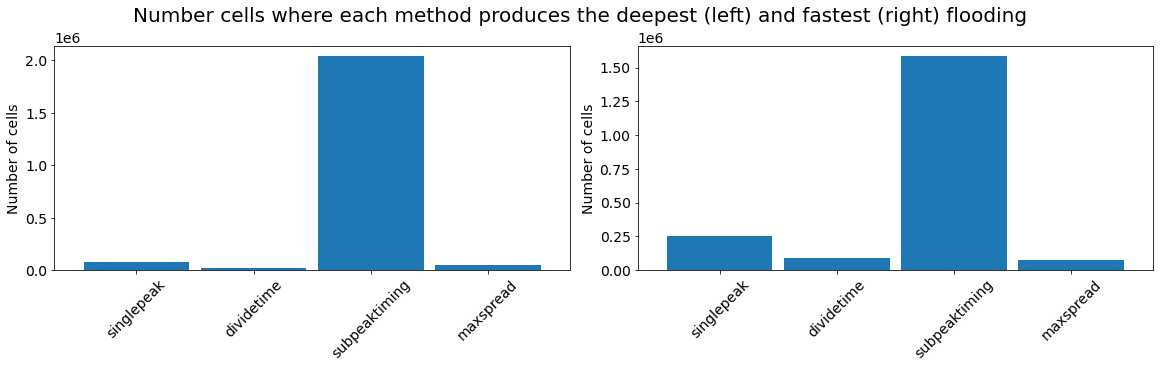

In [206]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (16,5))
fig.suptitle('Number cells where each method produces the deepest (left) and fastest (right) flooding', fontsize = 20)
subplot_n = [221, 222]
subplot_i = 0

for row, variable in enumerate(["depth", "velocity"]):
    if variable == 'depth':
        rasters_dict = depth_rasters_dict
    else:
        rasters_dict = velocity_rasters_dict
        
    worst_case_values =np.where((rasters_dict['singlepeak'] > rasters_dict['dividetime']) & (rasters_dict['singlepeak'] > rasters_dict['maxspread']) & (rasters_dict['singlepeak'] > rasters_dict['subpeaktiming']), rasters_dict['singlepeak'],
                         np.where((rasters_dict['dividetime'] > rasters_dict['subpeaktiming']) & (rasters_dict['dividetime'] > rasters_dict['maxspread']) & (rasters_dict['dividetime'] > rasters_dict['singlepeak']),rasters_dict['dividetime'],
                         np.where((rasters_dict['subpeaktiming'] > rasters_dict['dividetime']) & (rasters_dict['subpeaktiming'] > rasters_dict['maxspread']) & (rasters_dict['subpeaktiming'] > rasters_dict['singlepeak']), rasters_dict['subpeaktiming'],  
                         np.where((rasters_dict['maxspread'] > rasters_dict['dividetime']) & (rasters_dict['maxspread'] > rasters_dict['singlepeak']) & (rasters_dict['maxspread'] > rasters_dict['subpeaktiming']), rasters_dict['maxspread'],  
                         np.nan))))     

    worst_case_method =  np.where((rasters_dict['singlepeak'] > rasters_dict['dividetime']) & (rasters_dict['singlepeak'] > rasters_dict['maxspread']) & (rasters_dict['singlepeak'] > rasters_dict['subpeaktiming']), 0, 
                               np.where((rasters_dict['dividetime'] > rasters_dict['subpeaktiming']) & (rasters_dict['dividetime'] > rasters_dict['maxspread']) & (rasters_dict['dividetime'] > rasters_dict['singlepeak']),1,                    
                                np.where((rasters_dict['subpeaktiming'] > rasters_dict['dividetime']) & (rasters_dict['subpeaktiming'] > rasters_dict['maxspread']) & (rasters_dict['subpeaktiming'] > rasters_dict['singlepeak']), 2,  
                                np.where((rasters_dict['maxspread'] > rasters_dict['dividetime']) & (rasters_dict['maxspread'] > rasters_dict['singlepeak']) & (rasters_dict['maxspread'] > rasters_dict['subpeaktiming']), 3,   
                               np.nan))))     
    
    unique, counts = np.unique(worst_case_method, return_counts=True)
    worst_case_method_df = pd.DataFrame({'values': unique, 'counts':counts})
    
    worst_case_method_df = worst_case_method_df.iloc[:4,1]
    worst_case_method_df
    worst_case_method_df.index = ["singlepeak", "dividetime", "subpeaktiming", "maxspread"]
    worst_case_method_df.plot(ax= axs[row], kind ='bar',width=  0.9, rot =45, ylabel = 'Number of cells')    

In [57]:
# import rasterio
# fig, ax = plt.subplots(figsize = (30,20))
# pyplot.imshow(depth_raster, cmap = 'pink')

<AxesSubplot:>

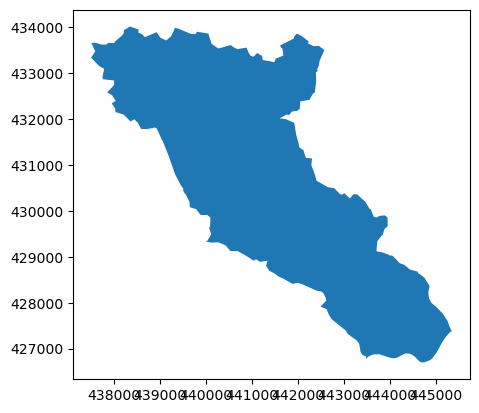

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
my_shp = "C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp"
gdf = gpd.read_file(my_shp)
gdf.plot()
# for row in gdf.iterrows():    
#     geom = gpd.GeoSeries(row[1].geometry)
#     geom.plot()

<AxesSubplot:>

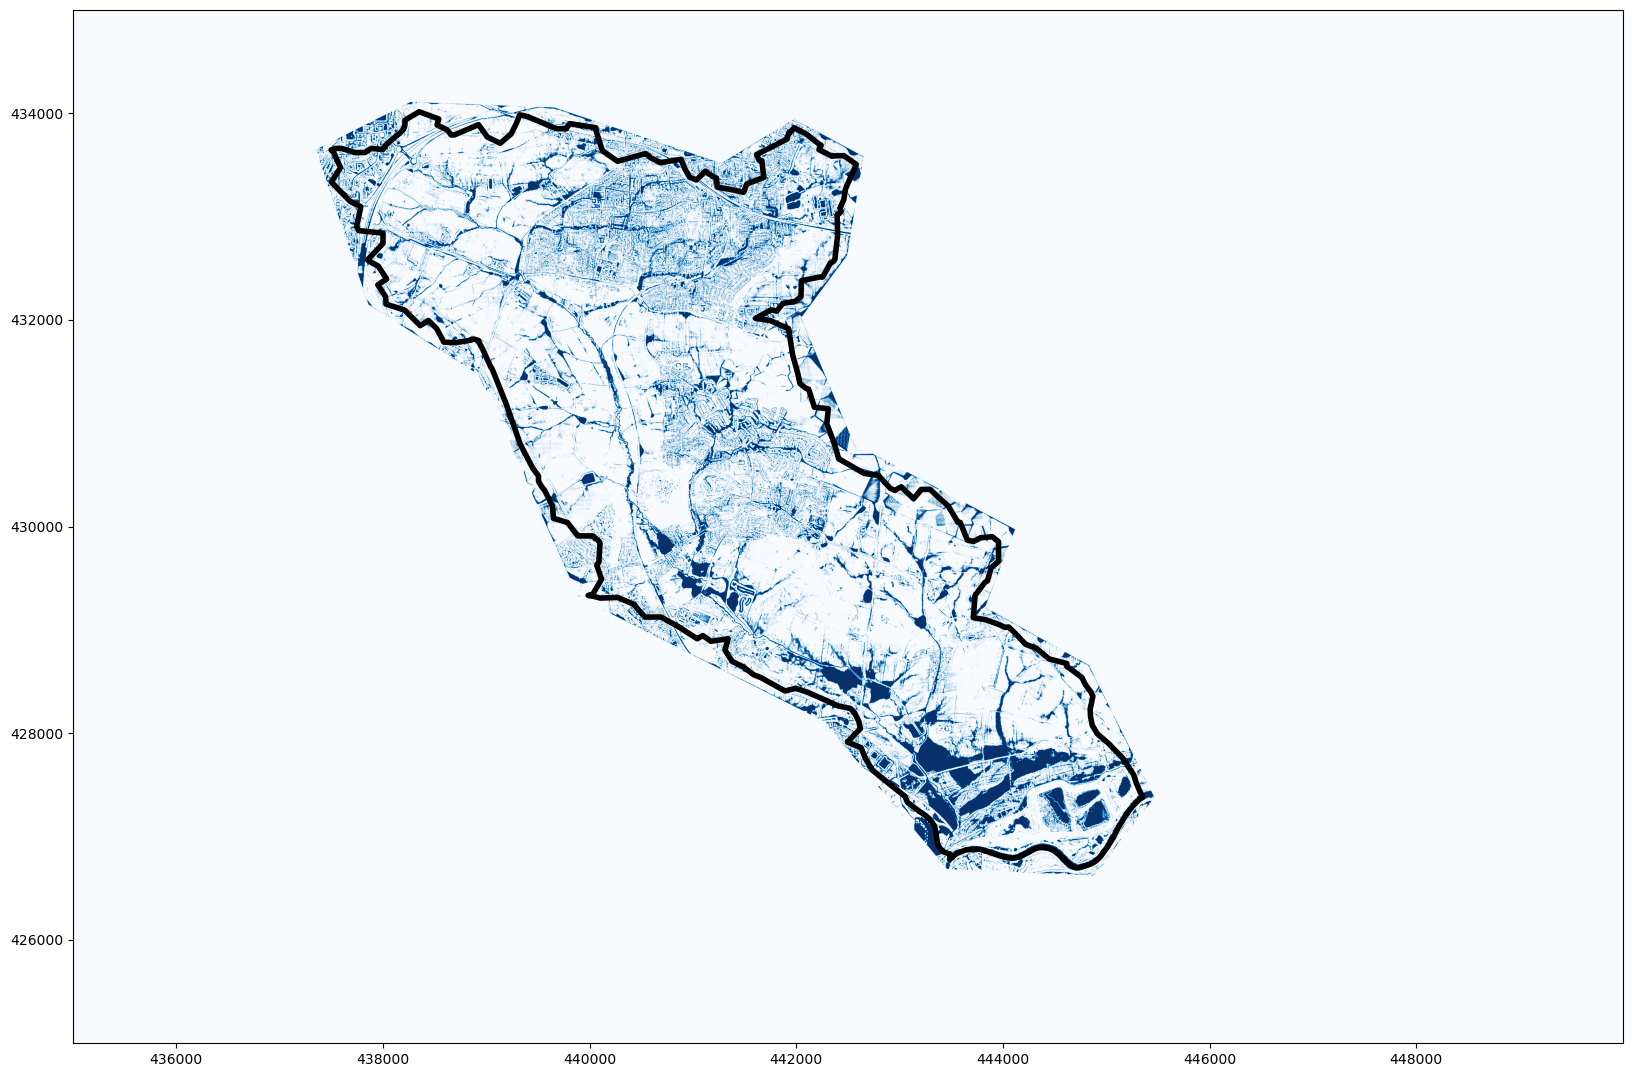

In [10]:
my_shp = "C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp"

fig, ax = plt.subplots(figsize=(20, 15))

src = rasterio.open("MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif")

with fiona.open("C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]


# # plot on the same axis with rio.plot.show
ax = mpl.pyplot.gca()
rasterio.plot.show((src, 1), ax= ax, cmap = 'Blues')
gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)

#                     vmin=np.nanmin(raster),  vmax=np.nanmax(raster))
# patches = [PolygonPatch(feature,  facecolor= 'green', edgecolor='k',) for feature in features]
# ax.add_collection(mpl.collections.PatchCollection(patches, facecolor = 'None', edgecolor = 'black', linewidth = 4))


In [6]:
# polys  = shp.Reader("C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp")
# fig = plt.figure() 
# ax = fig.gca() 
# ax.add_patch(PolygonPatch(polys, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
# ax.axis('scaled')
# plt.show()

NameError: name 'shp' is not defined

In [12]:
variable = 'depth'

for method_name, shortening in methods.items():    # Define filepath
    print(variable, method_name)
    # Read in the raster files
    raster = rasterio.open("MeganModel/{}_u/6hr_{}_{}.Resampled.Terrain.tif".format(shortening, method_name, variable)).read(1)
    # Set -9999 to NA
    np.nanmin(raster)
    raster[raster < -9998] = np.nan    
    # Set cell values to Null in cells which have a value <0.1 in the depth raster
    if remove_little_values == True:
         raster[raster < 0.1] = np.nan

depth singlepeak
depth dividetime
depth maxspread
depth subpeaktiming


In [10]:
# from rasterio import plot as rasterplot
# fig, ax = plt.subplots(figsize=(20, 15))

# src = rasterio.open("MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif")
# fp  = "MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif"
# # use imshow so that we have something to map the colorbar to
# image_hidden = ax.imshow(raster, 
#                          cmap='Blues') 
# #                          vmin=np.nanmin(raster), 
# #                          vmax=np.nanmax(raster))

# # plot on the same axis with rio.plot.show
# rasterplot.show((src, 1), 
#                       ax=ax, 
#                       cmap='Blues') 
# #                       vmin=np.nanmin(raster), 
# #                       vmax=np.nanmax(raster))


# # # add colorbar using the now hidden image
# fig.colorbar(image_hidden, ax=ax, fraction=0.03, pad=0.04)
# # plt.colorbar(im,fraction=0.046, pad=0.04)

In [11]:
# shapefile = gpd.read_file("C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp")
# shapefile = shapefile.to_crs('epsg:3035')
# shapefile = shapefile[shapefile.name == 'Germany']
# tiff = rasterio.open(fp)
# tiff_extent = [tiff.bounds[0], tiff.bounds[2], tiff.bounds[1], tiff.bounds[3]]


# fig, ax = plt.subplots(figsize = (30,20))

# # plot DEM
# rasterplot.show(
#     raster,  # use tiff.read(1) with your data
#     extent=tiff_extent,
#     ax=ax,

# )
# # plot shapefiles
# shapefile.plot(ax=ax, facecolor='w', edgecolor='k')
# # plt.savefig('test.jpg')
# plt.show()

# prov_shp=gpd.read_file("C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp" )
# # prov_shp.set_crs(epsg=4326, inplace=True)


In [12]:
# fp  = "MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif"
# with rasterio.open(fp) as src:
#     lidar_dem_im2 = src.read(1, masked=True)
#     sjer_ext = rasterio.plot.plotting_extent(src)
# plt.show()

In [19]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

# Import data
# data = et.data.get_data("colorado-flood")

# Set working directory
# os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

In [15]:
# Open raster data
lidar_chm_path = "MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif"

lidar_chm = rxr.open_rasterio(lidar_chm_path, masked=True).squeeze()

In [23]:
cmap = ListedColormap(["white", "tan", "springgreen", "darkgreen"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 2, 10, 20, 30], 5)
norm

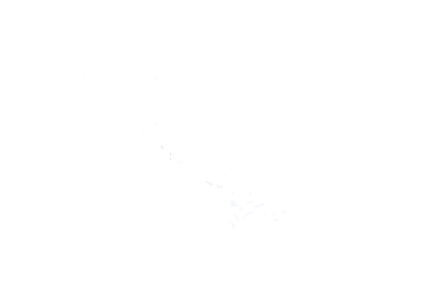

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))

chm_plot = ax.imshow(lidar_chm, cmap= 'Blues')

# ax.set_title("Lidar Canopy Height Model (CHM)")

# # Add a legend for labels
# legend_labels = {"tan": "short", 
#                  "springgreen": "medium", 
#                  "darkgreen": "tall"}

# patches = [Patch(color=color, label=label)
#            for color, label in legend_labels.items()]

# ax.legend(handles=patches,
#           bbox_to_anchor=(1.35, 1),
#           facecolor="white")

ax.set_axis_off()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

chm_plot = ax.imshow(lidar_chm,
                     cmap=cmap,
                     norm=norm)

ax.set_title("Lidar Canopy Height Model (CHM)")

# Scale color bar to the height of the plot
cbar = ep.colorbar(chm_plot)

boundary_means = [np.mean([norm.boundaries[ii], norm.boundaries[ii - 1]])
                  for ii in range(1, len(norm.boundaries))]

category_names = ['No vegetation', 'Short', 'Medium', 'Tall']
cbar.set_ticks(boundary_means)
cbar.set_ticklabels(category_names)

ax.set_axis_off()
plt.show()

In [ ]:
####################

In [28]:
# Import needed packages
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import rioxarray as rxr
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Set figure size and title size of plots
mpl.rcParams['figure.figsize'] = (14, 14)
mpl.rcParams['axes.titlesize'] = 20

In [11]:
# Import fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

# Open fire boundary data with geopandas
fire_boundary = gpd.read_file("C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp")

In [26]:
from rasterio.plot import plotting_extent
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
data = rxr.open_rasterio(lidar_chm_path, masked=True)
data_plotting_extent = plotting_extent(data[0], data.rio.transform())
data_plotting_extent

(434999.9968, 449999.9968, 424999.9998, 434999.9998)

In [24]:
# Define path to NAIP data
naip_path = lidar_chm_path
# Getting the crs of the raster data
naip_crs = es.crs_check(naip_path)

# Transforming the fire boundary to the NAIP data crs
fire_bound_utmz13 = fire_boundary.to_crs(naip_crs)

# Opening the NAIP data
naip_data = rxr.open_rasterio(naip_path, masked=True)

# Creating the plot extent object
naip_plot_extent = plotting_extent(naip_data[0], 
                                   naip_data.rio.transform())

IndexError: index 1 is out of bounds for axis 0 with size 1

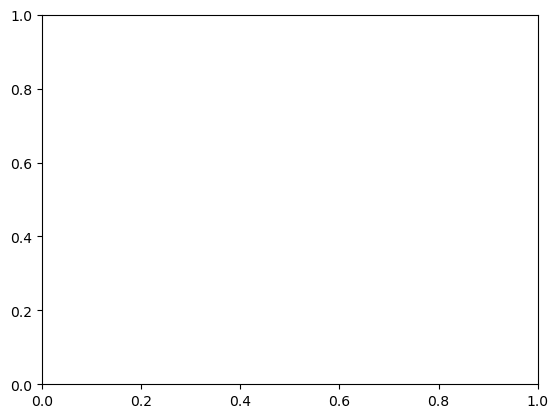

In [27]:
# f, ax = plt.subplots()

# ep.plot_rgb(naip_data.values,
#             rgb=[0, 1, 2],
#             ax=ax,
#             title="Fire boundary overlayed on top of uncropped NAIP data",
#             extent=naip_plot_extent)  # Use plotting extent from DatasetReader object

# fire_bound_utmz13.plot(ax=ax)

# plt.show()

In [6]:
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs

In [8]:
lidar_chm_path = "MeganModel/6hr_dt_u/6hr_dividetime_velocity.Resampled.Terrain.tif"
data = rasterio.open(lidar_chm_path)

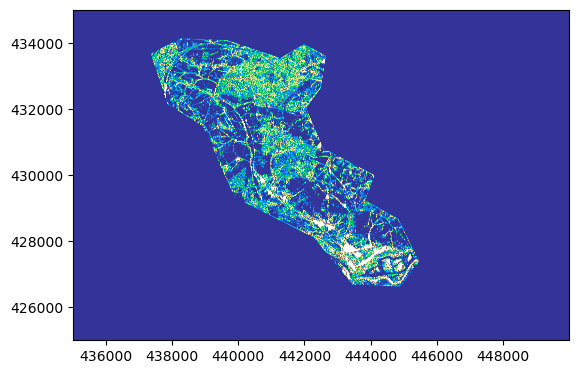

<AxesSubplot:>

In [9]:
show((data, 1), cmap='terrain')

In [28]:
from pyproj import CRS
minx, miny = 438000,  428000
maxx, maxy = 446000, 434000
bbox = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=CRS('EPSG:27700'))             

In [11]:
geo = geo.to_crs(crs=data.crs.data)

C:\Users\gy17m2a\Anaconda3\envs\pyproj_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [13]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[446000.0, 428000.0], [446000.0, 434000.0], [438000.0, 434000.0], [438000.0, 428000.0], [446000.0, 428000.0]]]}]


In [14]:
out_img, out_transform = mask(data, shapes=coords, crop=True)

In [15]:
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 15000, 'height': 10000, 'count': 1, 'crs': CRS.from_epsg(27700), 'transform': Affine(1.0, 0.0, 434999.9968,
       0.0, -1.0, 434999.9998)}


In [16]:
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

27700


In [17]:
# out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2], "transform": out_transform,
#                 "crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4()})

AttributeError: module 'pycrs' has no attribute 'parser'

In [22]:
out_tif = "test.tif"
with rasterio.open(out_tif, "w", **out_meta) as dest:
       dest.write(out_img)

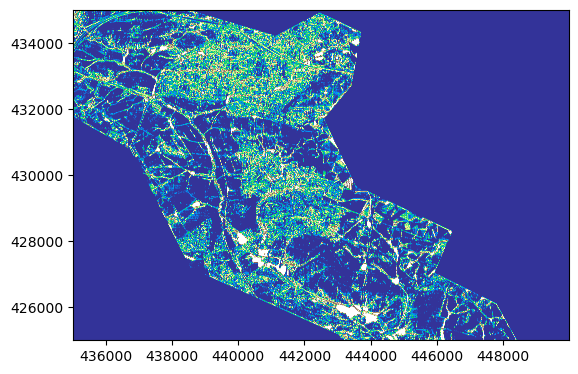

<AxesSubplot:>

In [24]:
clipped = rasterio.open(out_tif)

show((clipped, 1), cmap='terrain')

In [34]:
# show(out_img, cmap = 'terrain')

<AxesSubplot:>

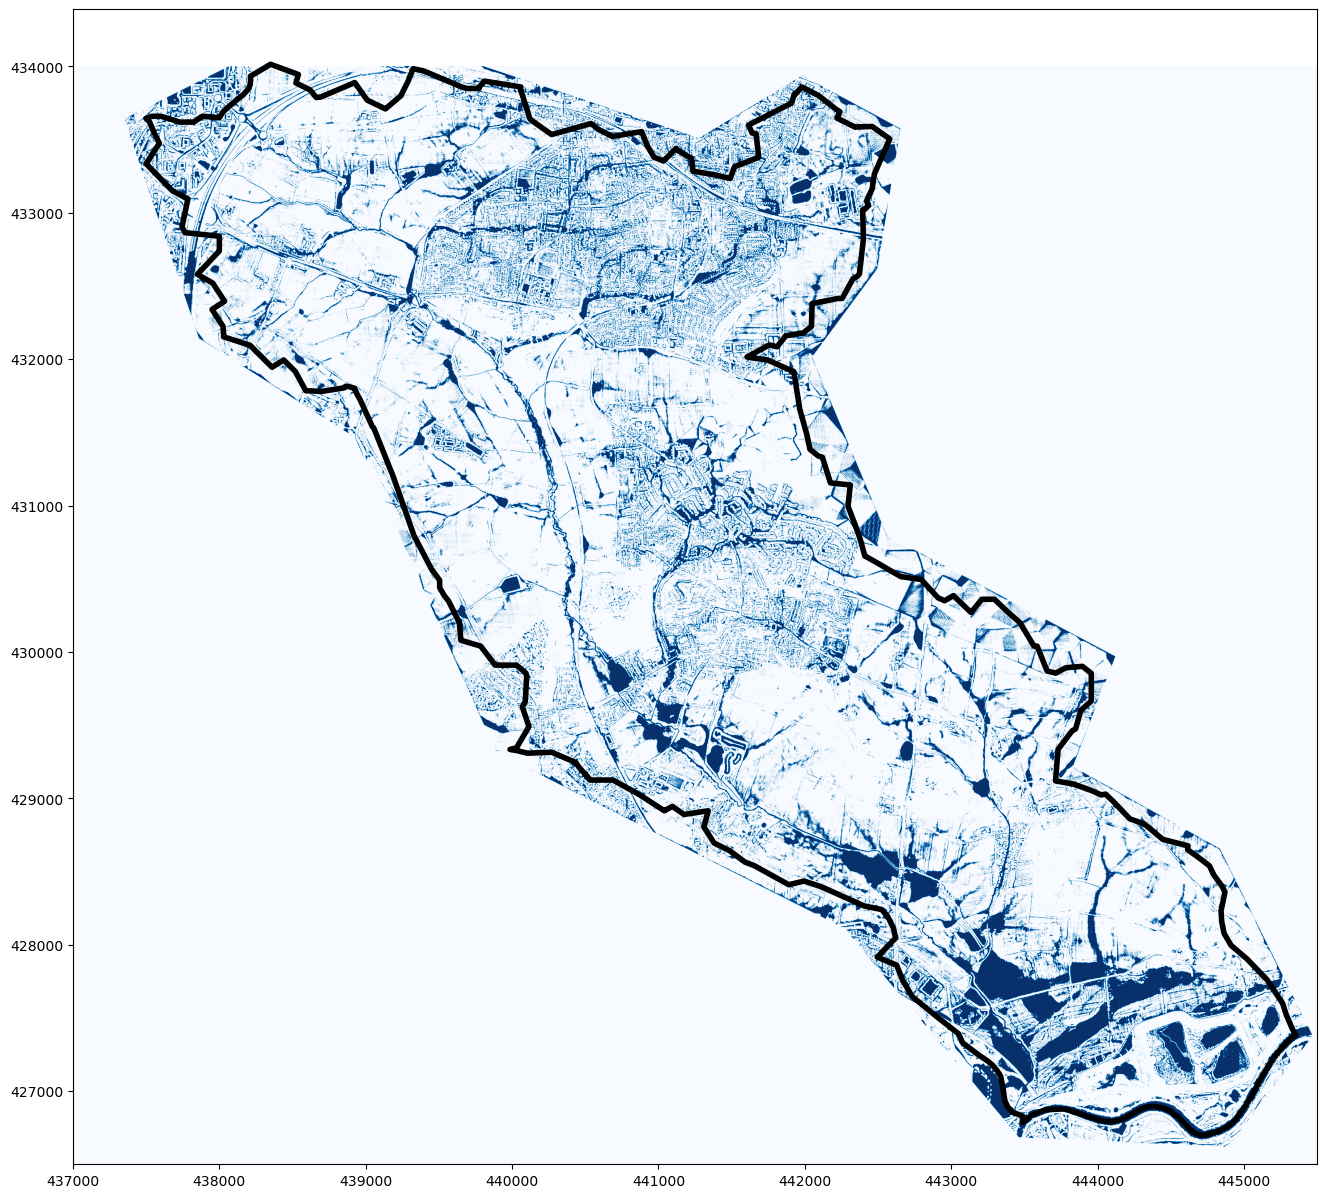

In [47]:
fig, ax = plt.subplots(figsize=(20, 15))

my_shp = "C:/Users/gy17m2a/OneDrive - University of Leeds/PhD/DataAnalysis/FloodModelling/MeganModel/CatchmentLinDyke_exported.shp"
gdf = gpd.read_file(my_shp)

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

minx, miny = 437000,  426500
maxx, maxy = 445500, 434000
bbox = box(minx, miny, maxx, maxy)
# geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(27700))
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=CRS('EPSG:27700'))     

geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data

coords = getFeatures(geo)
# print(coords)

out_img, out_transform = mask(data, shapes=coords, crop=True)

out_meta = data.meta.copy()
# print(out_meta)

out_meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2], "transform": out_transform,
                 "crs": CRS('EPSG:27700')})#pycrs.parser.from_epsg_code(epsg_code).to_proj4()})
# data.meta.update({"driver": "GTiff","height": out_img.shape[1],"width": out_img.shape[2], "transform": out_transform})

epsg_code = int(data.crs.data['init'][5:])
# print(epsg_code)

# show(out_img, cmap = 'terrain')

out_tif = "test1.tif"
with rasterio.open(out_tif, "w", **out_meta) as dest:
       dest.write(out_img)
        
clipped = rasterio.open(out_tif)

# show((clipped, 1), cmap='terrain')

ax = mpl.pyplot.gca()
rasterio.plot.show((clipped, 1), ax= ax, cmap = 'Blues')
gdf.plot(ax=ax, facecolor = 'None', edgecolor = 'black', linewidth = 4)